In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastpapers

In [ ]:
#all_slow

In [ ]:
# default_exp carion2020end

# End-to-End Object Detection with Transformers

Carion, N., Massa, F., Synnaeve, G., Usunier, N., Kirillov, A., & Zagoruyko, S. (2020). End-to-End Object Detection with Transformers. arXiv preprint arXiv:2005.12872.

In [ ]:
#export
import os
import torch
import numpy as np
import seaborn as sns
import io
from contextlib import redirect_stdout
from IPython.core.debugger import set_trace
from torch import functional as F
from scipy.optimize import linear_sum_assignment
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.data.all import *
from fastai.vision.all import *
from fastpapers.core import *
from itertools import chain
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from fastpapers.core import _parent_idxs

## The data

We are going to need the `coco_vocab` in it's original order to use the DETR pretrained models.

In [ ]:
#export
coco_vocab = [
    'N/A0', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A1',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A2', 'backpack',
    'umbrella', 'N/A3', 'N/A4', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A5', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A6', 'dining table', 'N/A7',
    'N/A8', 'toilet', 'N/A9', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A10',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [ ]:
coco_source = download_coco()
img2bbox = {}
for ann_file in [coco_source['val_ann'], coco_source['train_ann']]:
    images, lbl_bbox = get_annotations(ann_file)
    img2bbox = merge(img2bbox, dict(zip(images, lbl_bbox)))
vocab = L(coco_vocab) + '#na#'

We have to change `bb_pad` so it does nothing if there are no bounding boxes and classes. This is needed when we are decoding.

In [ ]:
# #export
def bb_pad(samples, pad_idx=0):
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    if len(samples[0][1:])>0:
        samples = [(s[0], *clip_remove_empty(*s[1:])) for s in samples]
        max_len = max([len(s[2]) for s in samples])
        def _f(img,bbox,lbl):
            bbox = torch.cat([bbox,bbox.new_zeros(max_len-bbox.shape[0], 4)])
            lbl  = torch.cat([lbl, lbl .new_zeros(max_len-lbl .shape[0])+pad_idx])
            return img,bbox,lbl
        return [_f(*s) for s in samples]
    else:
        return samples

In [ ]:
BBoxBlock.dls_kwargs = {'before_batch': partial(bb_pad, pad_idx=len(vocab)-1)}

We create a `ParentSplitter` which can split files into validation and training set based on the parent folder. This is how the coco dataset is structured.

In [ ]:
#export
def ParentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        tindex = _parent_idxs(o, train_name)
        vindex = _parent_idxs(o, valid_name)
        return tindex, vindex
    return _inner

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock(vocab=list(vocab), add_na=False)), 
                 get_items=compose(get_image_files, partial(filter, lambda x:x.name in img2bbox), L),
                 splitter=ParentSplitter(train_name='train2017', valid_name='val2017'),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(800),
                 batch_tfms=None,
                 n_inp=1)

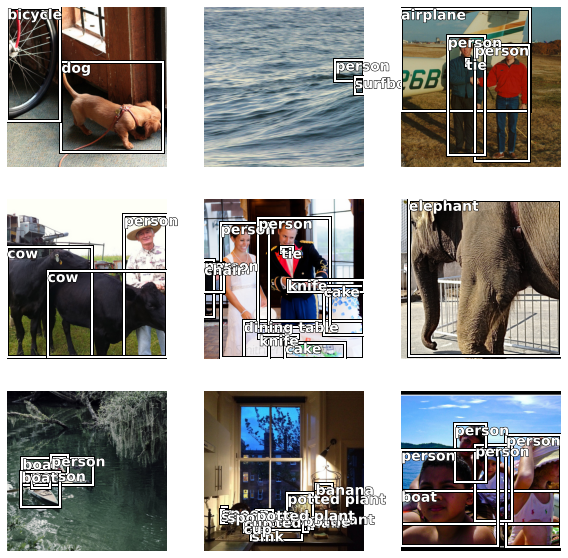

In [ ]:
dls = coco.dataloaders(coco_source['base'], bs=16, num_workers=0)#
b = dls.one_batch()
dls.show_batch(b, figsize=(10, 10))

## Box utils

Bounding boxes come in two flavors:
 - xyxy where the four cordinates are the top left corner and the bottom right corner [left, top, bottom, right]
 - cxcxxy where the first two elements are the xy coordinates of the center and third and four elements are the width and hight of the box.

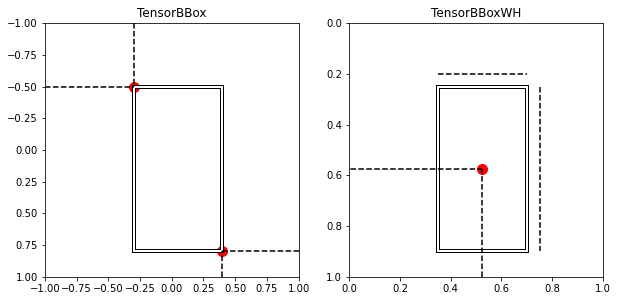

In [ ]:
#hide_input
fix, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
ax0.set_xlim([-1, 1]); ax0.set_ylim([1, -1]); 
ax1.set_xlim([0, 1]); ax1.set_ylim([1, 0]); 

L(ax0, ax1).map(methodcaller('set_aspect', 'equal'))
x0, y0, x1, y1 = -.3, -0.5, 0.4, 0.8
TensorBBox([x0, y0, x1, y1]).show(ax0)
TensorPoint([x0, y0]).show(ax0, s=400)
TensorPoint([x1, y1]).show(ax0, s=400)
ax0.hlines(y0, -1, x0, colors='k', linestyle='--')
ax0.hlines(y1, x1, 1, colors='k', linestyle='--')
ax0.vlines(x0, -1, y0, colors='k', linestyle='--')
ax0.vlines(x1, 1, y1, colors='k', linestyle='--')
ax0.set_title('TensorBBox')
ax1.set_title('TensorBBoxWH')
x0, y0, x1, y1 = (x0+1)/2, (y0+1)/2, (x1+1)/2, (y1+1)/2
TensorBBox([x0, y0, x1, y1]).show(ax1)
cx, cy, w, h = (x0+x1)/2, (y0+y1)/2, x1-x0, y1-y0
TensorPoint([cx, cy]).show(ax1, s=400)
ax1.hlines(cy, -1, cx, colors='k', linestyle='--')
ax1.vlines(cx, 1, cy, colors='k', linestyle='--')
ax1.vlines(x1+0.05, y0, y1, colors='k', linestyle='--')
ax1.hlines(y0-0.05, x0, x1, colors='k', linestyle='--');

`box_cxcywh_to_xyxy` and `box_xyxy_to_cxcywh` allow you to convert from one format to the other.

In [ ]:
#export
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

In [ ]:
x = torch.rand(4, 7, 4)
y = box_cxcywh_to_xyxy(x)
test_eq(y.shape, x.shape)

In [ ]:
#export
def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    b = [(x0 + x1) / 2, (y0 + y1) / 2,
         (x1 - x0), (y1 - y0)]
    return torch.stack(b, dim=-1)

Also, FastAI uses normalized coordinates from -1 to 1 (with its origin at the center of the image), but the DETR model output uses coordinates normalized from 0 to 1, with origin at the top left corner.

To handle all this option we use three classes (I did not need the four category):

- `TensorBBox`: for xyxy bbox centered and from -1 to 1
- `TensorBBoxWH` for cxxy xy bbox with origin in the top left corner and scale form 0 to 1
- `TensorBBoxTL` for xyxy bbox with origin inthe top left corner and scale from 0 to 1

In [ ]:
# class TensorBBox(TensorPoint):
#     "Basic type for a tensor of bounding boxes in an image"
#     @classmethod
#     def create(cls, x, img_size=None)->None: return cls(tensor(x).view(-1, 4).float(), img_size=img_size)

In [ ]:
#export
class TensorBBoxWH(TensorPoint): pass
class TensorBBoxTL(TensorPoint): pass

In [ ]:
#export
@Transform
def ToWH(x:TensorBBox): return TensorBBoxWH(box_xyxy_to_cxcywh(x*0.5+0.5), img_size=x.img_size)

In [ ]:
bbox = b[1]
bboxwh = TensorBBoxWH(box_xyxy_to_cxcywh(b[1]*0.5+0.5), img_size=bbox.img_size)
test_eq_type(ToWH(bbox), bboxwh)

In [ ]:
#export
@Transform
def ToXYXY(x:TensorBBoxWH)->None: 
    return TensorBBox(box_cxcywh_to_xyxy(x)*2-1, img_size=x.img_size)

In [ ]:
test_close(bbox, ToXYXY(bboxwh))
test_eq(type(bbox), type(ToXYXY(bboxwh)))

In [ ]:
#export
class ToTL(Transform):
    def encodes(self, x:TensorBBoxWH)->None: return TensorBBoxTL(box_cxcywh_to_xyxy(x), img_size=x.img_size)
    def encodes(self, x:TensorBBox)->None: return TensorBBoxTL((x+1)/2, img_size=x.img_size)

In [ ]:
bwh = TensorBBoxWH(box_xyxy_to_cxcywh(b[1]*0.5+0.5), img_size=b[1].img_size)

test_eq(ToXYXY(b[1]), b[1])
test_ne(ToWH(b[1]), b[1])
test_eq_type(ToWH(b[1]), bwh)
test_close(ToXYXY(bwh), b[1])

In [ ]:
#export
def box_area(boxes): return (boxes[..., 2] - boxes[..., 0]) * (boxes[..., 3] - boxes[..., 1])

In [ ]:
#hide
def rand_box_xyxy(shape): return box_cxcywh_to_xyxy(torch.rand(shape[0], shape[1], 4))*2 - 1

In [ ]:
#export
def all_op(cmp):
    "Compares all the elements of `a` and `b` using cmp."
    def _inner(a, b):
        if not is_iter(b): return False
        return all(cmp(a_,b_) for a_,b_ in itertools.zip_longest(a,b))
    return _inner

The generalized box iou function is a copy of the  [DETR original implementation](https://github.com/facebookresearch/detr/blob/b7b62c080d34f76c0069a63afcfb9093213d235c/util/box_ops.py). This implementation can handle batched boxes and two type of comparisons: element wise or pairwise.

In [ ]:
#export
def generalized_box_iou(boxes1, boxes2, pairwise=False):
    """
    Generalized IoU from https://giou.stanford.edu/
    The boxes should be in [x0, y0, x1, y1] format
    Returns a [N, M] pairwise matrix, where N = len(boxes1)
    and M = len(boxes2). 
    This implemenation expects bs as first dim.
    """
    # degenerate boxes gives inf / nan results
    # so do an early check
    #pexpt((boxes1, boxes2))
    #set_trace()
    boxes1, boxes2 = ToTL()((boxes1, boxes2))
    #pexpt((boxes1, boxes2))
    assert (boxes1[..., 2:] >= boxes1[..., :2]).all(), 'boxes1 are not in [left_x, top_y, right_x, bottom_y] coords'
    assert (boxes2[..., 2:] >= boxes2[..., :2]).all(), 'boxes2 are not in [left_x, top_y, right_x, bottom_y] coords'
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    
    if pairwise:
        boxes1 = boxes1[:, :, None, :]
        boxes2 = boxes2[:, None, :, :]
        area1 = area1[:, :, None]
        area2 = area2[:, None, :]
    lt = torch.max(boxes1[..., :2], boxes2[..., :2])  # [N,M,2]
    rb = torch.min(boxes1[..., 2:], boxes2[..., 2:])  # [N,M,2]
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[..., 0] * wh[..., 1]  # [N,M]
    union = (area1 + area2) - inter
    iou = inter / union

    lt = torch.min(boxes1[..., :2], boxes2[..., :2])  # [N,M,2]
    rb = torch.max(boxes1[..., 2:], boxes2[..., 2:])  # [N,M,2]
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    area = wh[..., 0] * wh[..., 1]
    
    #set_trace()
    return iou - (area - union) / area

In [ ]:
b1 = box_cxcywh_to_xyxy(torch.rand(2, 5, 4))
b2 = box_cxcywh_to_xyxy(torch.rand(2, 3, 4))
giou = generalized_box_iou(b1, b2, pairwise=True)
test_eq(giou.shape, torch.Size((b1.shape[0], b1.shape[1], b2.shape[1])))

In [ ]:
x = tensor([[[-.5, -.5, 0, 0], [-.25, -.25, .25, .25],[0, 0, .5, .5], [.25, .25, .75, .75]]])
y = tensor([[[-.5, -.5, .5, .5]]])-0.5
l_iou = -generalized_box_iou(x*0.5+0.5, x*0.5+0.5, pairwise=True)
test(l_iou[0,0,:-1], l_iou[0,0, 1:], all_op(lt))

## The Loss

This is a reimplementation of the original code. here we put together [the matcher](https://github.com/facebookresearch/detr/blob/b7b62c080d34f76c0069a63afcfb9093213d235c/models/matcher.py#L12) and the [criterion](https://github.com/facebookresearch/detr/blob/b7b62c080d34f76c0069a63afcfb9093213d235c/models/detr.py#L74) into the `DETRLoss` Module.

In [ ]:
#export
class DETRLoss(nn.Module):
    def __init__(self, classw=1, boxw=1, giouw=1, n_queries=100, th=0.7, eos_coef=0.1, n_classes=92):
        super().__init__()
        store_attr()
        self.emptyw = torch.ones(n_classes)
        self.emptyw[-1] = eos_coef
        self.entropy = nn.CrossEntropyLoss(weight=self.emptyw)

    def class_loss(self, output_classes, target_id, indices):
        bs, nq, nc = output_classes.shape
        target_id_full = torch.full((bs, nq), nc-1, dtype=torch.int64, device=target_id.device)
        for i, ind in enumerate(indices): target_id_full[i, ind[0]] = target_id[i, ind[1]]
        return self.entropy(output_classes.transpose(1,2), target_id_full)
    
    def box_loss(self, output_boxes, target_boxes, indices):
        output_boxes, target_boxes = ToWH((output_boxes, target_boxes))
        
        output_boxes_ind = []
        target_boxes_ind = []
        for i, (src, dst) in enumerate(indices):
            output_boxes_ind.append(output_boxes[i, src, :])
            target_boxes_ind.append(target_boxes[i, dst, :])
        output_boxes_ind = torch.cat(output_boxes_ind)
        target_boxes_ind = torch.cat(target_boxes_ind)
        l1_loss = nn.L1Loss()(output_boxes_ind, target_boxes_ind)
        giou = 1 - generalized_box_iou(output_boxes_ind, target_boxes_ind)
        return self.boxw * l1_loss + self.giouw * giou.mean()
        
    def box_cost(self, output_boxes, target_boxes):
        output_boxes, target_boxes = ToWH((output_boxes, target_boxes))
        return torch.cdist(output_boxes, target_boxes, p=1)
    
    def class_cost(self, output_class, target_ids):
        bs, nq, _ = output_class.shape
        _, mc = target_ids.shape
        p = output_class.flatten(0,1).softmax(-1) # [bs*nq, num_classes]
        ids = target_ids.flatten() # [bs*nq]
        loss = -p[:, ids].reshape(bs, nq, -1) # [bs, nq, bs*mc]
        return torch.cat([loss[i, :, i*mc:(i+1)*mc][None, ...] for i in range(bs)], 0) # [bs, nq, mc]
            
        
    @torch.no_grad()
    def matcher(self, output, target):
        output_boxes, output_class = output # [bs, nq, 4], [bs, nq, num_classes]
        target_boxes, target_ids = target # [bs, max(n in batch), 4], [bs, max(n in batch)]

        l_iou = -generalized_box_iou(output_boxes, target_boxes, pairwise=True)
        l_box = self.box_cost(output_boxes, target_boxes)
        l_class = self.class_cost(output_class, target_ids)

        C = self.classw*l_class + self.boxw*l_box + self.giouw*l_iou
        C = C.cpu()
        sizes = [(v<self.n_classes-1).type(torch.int).sum() for v in target[1]]
        Cs = [C[i, :, :s] for i, s in enumerate(sizes)]

        indices = [linear_sum_assignment(C[i, :, :s]) for i, s in enumerate(sizes)]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]
    
    def forward(self, output, target_boxes, target_ids):
        output_boxes, output_class, aux_outputs = output
        indices = self.matcher((output_boxes, output_class), (target_boxes, target_ids))
        l_class = self.class_loss(output_class, target_ids, indices)
        l_box = self.box_loss(output_boxes, target_boxes, indices)
        loss = l_class * self.classw  + l_box
        if aux_outputs:
            for output in aux_outputs:
                output_boxes, output_class = output['pred_boxes'], output['pred_logits']
                indices = self.matcher((output_boxes, output_class), (target_boxes, target_ids))
                l_class = self.class_loss(output_class, target_ids, indices)
                l_box = self.box_loss(output_boxes, target_boxes, indices)
                loss += l_class * self.classw  + l_box                
        
        return loss

    def activation(self, x): return (ToXYXY(x[0]), F.softmax(x[1], dim=-1))

    def decodes(self, x, pad=True):
        pred_boxes, probs = x
        max_probs, pred_ids = probs.max(axis=-1)
        ind = (max_probs>self.th) & (pred_ids<probs.shape[-1]-1) & (box_area(pred_boxes)>0)
        
        max_probs = [max_probs[i, ind[i]] for i in range(ind.shape[0])] 
        pred_ids = [pred_ids[i, ind[i]] for i in range(ind.shape[0])]
        #pred_boxes = L([pred_boxes[i, ind[i], :] for i in range(ind.shape[0])]).map(TensorBBox)
        pred_boxes = L(pred_boxes[i, ind[i], :] for i in range(ind.shape[0]))
        if pad:
            imgs = [None for i in range_of(pred_ids)]
            z_inp = zip(imgs ,pred_boxes, pred_ids)
            out = bb_pad(list(z_inp), pad_idx=self.n_classes-1)
            pred_boxes = torch.cat([x[1].unsqueeze(0) for x in out])
            pred_ids = torch.cat([x[2].unsqueeze(0) for x in out])
            pred_boxes, pred_ids = TensorBBox(pred_boxes), TensorMultiCategory(pred_ids)
        self.scores = max_probs
        return pred_boxes, pred_ids

In [ ]:
#hide
b = to_cpu(b)
loss = DETRLoss(classw=1, boxw=1, giouw=1,eos_coef=0.1)

c=len(dls.vocab)
bs = b[0].shape[0]
ohts = []
for bi in b[2]:
    ohts.append([])
    for el in bi:
        ohts[-1].append(one_hot(el, c)[None,:])
        
    ohts[-1] = torch.cat(ohts[-1])[None, :]
true_classes = torch.cat(ohts).float()

good_output_bbox = torch.zeros(b[1].shape[0], 100, 4)
good_output_bbox[:, :b[1].shape[1], :] = box_xyxy_to_cxcywh(b[1]*0.5+0.5)

good_output_classes = torch.zeros(b[2].shape[0], 100, c) 
good_output_classes[:, true_classes.shape[1]:, -1] = 1
good_output_classes[:, :true_classes.shape[1], :] = true_classes
good_output_bbox = TensorBBoxWH(good_output_bbox, img_size=tuple(b[0].shape[2:]))
good_loss = loss((good_output_bbox, good_output_classes*100, None), *b[1:])
test(good_loss, 0.01, lt)

In [ ]:
rout = [torch.rand(bs, 100, 4), torch.rand(bs, 100, c)]
rout[0] = box_cxcywh_to_xyxy(rout[0])
random_loss =loss(rout+[None], *b[1:])
test(good_loss, random_loss, lt)

## Model

We do not reimplement the model, we only wrap it into a Module that sets the model and casts the outputs.

In [ ]:
#export
class DETR(nn.Module):
    def __init__(self, pretrained=True, n_classes=92, aux_loss=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=pretrained)
        if self.model.class_embed.out_features!=n_classes:
            self.model.class_embed = nn.Linear(256, n_classes)
        self.model.aux_loss = aux_loss
    def forward(self, x):
        img_sz = x.shape[2:]
        x = self.model(x)
        
        pred_boxes, pred_logits = x['pred_boxes'], x['pred_logits']
        aux_outputs = x.get('aux_outputs', None)
        if aux_outputs: 
            for o in aux_outputs: o['pred_boxes'] = TensorBBoxWH(o['pred_boxes'], img_size=img_sz)
        return TensorBBoxWH(pred_boxes, img_size=img_sz), pred_logits, aux_outputs

## Test model

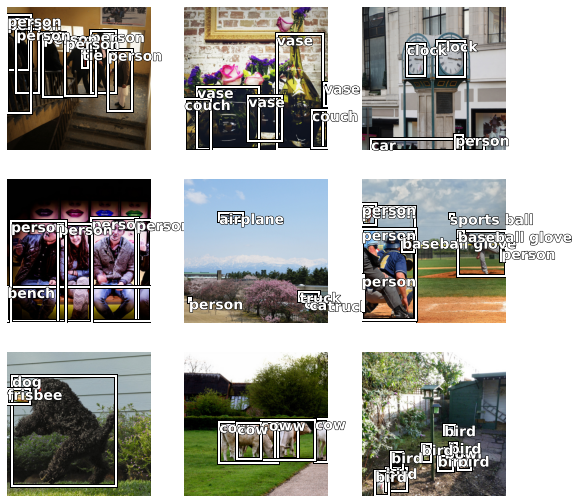

In [ ]:
dls.show_batch(b)

In [ ]:
model = DETR(pretrained=False).eval();
model.eval()
img = b[0]
bs = b[0].shape[0]
out_val = model(img)
test_eq(len(out_val), 3)
test_eq(out_val[0].shape, torch.Size((bs, 100, 4)))
test_eq(out_val[1].shape, torch.Size((bs, 100, 92)))

Using cache found in /home/andres/.cache/torch/hub/facebookresearch_detr_master


Using cache found in /home/andres/.cache/torch/hub/facebookresearch_detr_master


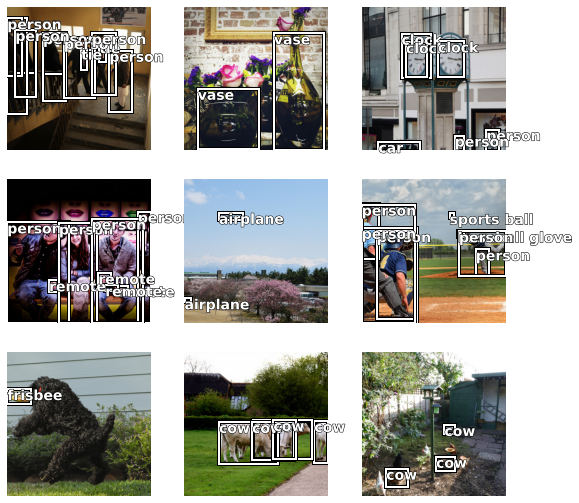

In [ ]:
model = DETR(pretrained=True).eval();
model.eval()
img = b[0]
out_val = model(to_cpu(img))
loss = DETRLoss()
out_val_act = loss.decodes(loss.activation(out_val))
bb = (img, out_val_act[0], out_val_act[1])
dls.show_batch(bb)

In [ ]:
model = DETR(pretrained=True, aux_loss=True)
model.train()
out = model(to_cpu(img))

Using cache found in /home/andres/.cache/torch/hub/facebookresearch_detr_master


## Detection Metrics

The `CocoEval` Callback gathers annotations and prediction during validation and computes the detection metrics using the `pycocotools` package.

In [ ]:
#export
class CocoEval(Callback):
    run_before=Recorder
    run_train = False
    def __init__(self): 
        metrics = 'AP AP50 AP75 AP_small AP_medium AP_large AR1 AR10 AR100 AR_small AR_medium AR_large'.split()
        self.metrics = L(metrics).map(partial(getattr, self)).map(ValueMetric)

    def before_validate(self):
        vocab = self.dls.vocab
        bs = self.learn.dls.bs
        self.gt_ds = {'annotations': [], 'images': [], 'categories': []}
        self.dt_ds = {'annotations': [], 'images': [], 'categories': []}
        self.gt_ds['categories'] = [{'id': i+1,'name':o} for i,o in enumerate(vocab)]
        self.dt_ds['categories'] = [{'id': i+1,'name':o} for i,o in enumerate(vocab)]
        
        self.reset_counters()
        self.bs = bs
        self.dec_bbox = compose(ToXYXY, to_cpu, self.learn.dls.after_item.decode)#
        self.dec_cls = compose(to_cpu, lambda x: x[x>0])
        
        self.batch_to_samples = compose(partial(batch_to_samples, max_n=self.bs), L)
    def reset_counters(self):
        self.img_id = Inf.count
        self.gtann = Inf.count
        self.dtann = Inf.count
    def after_batch(self):
        pred_boxes, pred_ids = self.learn.loss_func.decodes(self.loss_func.activation(self.pred), pad=False)
        max_probs = self.learn.loss_func.scores
        _, _, w, h = self.xb[0].shape
        gt_cls = self.batch_to_samples(self.yb[1]).map(to_cpu)
        dt_cls = L(pred_ids).map(to_cpu)
        gt_boxes = self.batch_to_samples(self.yb[0]).map(self.dec_bbox)
        dt_boxes = L(pred_boxes).map(self.dec_bbox)
        for gtb, gtc, dtb, dtc, i, socres in zip(gt_boxes, gt_cls, dt_boxes, dt_cls, self.img_id, max_probs):
            self.gt_ds['images'].append({'id': i, 'height': h, 'width': w})
            self.gt_ds['annotations'].extend([{'iscrowd': 0, 'bbox': o.tolist(), 'area': box_area(o), 'category_id': int(c), 'image_id': i, 'id': j} for o, c, j in zip(gtb, gtc, self.gtann)])
            self.dt_ds['images'].append({'id': i, 'height': h, 'width': w})
            self.dt_ds['annotations'].extend([{'iscrowd': 0, 'score': s, 'bbox': o.tolist(), 'area': box_area(o), 'category_id': int(c), 'image_id': i, 'id': j} for o, c, j, s in  zip(dtb, dtc, self.dtann, socres)])

    def after_validate(self):
        with redirect_stdout(io.StringIO()):
            gt = COCO()
            gt.dataset = self.gt_ds
            gt.createIndex()
            dt = COCO()
            dt.dataset = self.dt_ds
            dt.createIndex()
            coco_eval = COCOeval(gt, dt, iouType='bbox')
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
            self.stats = coco_eval.stats
            self.reset_counters()
    def AP(self): return self.stats[0]
    def AP50(self): return self.stats[1]
    def AP75(self): return self.stats[2]
    def AP_small(self): return self.stats[3]
    def AP_medium(self): return self.stats[4]
    def AP_large(self): return self.stats[5]
    def AR1(self): return self.stats[6]
    def AR10(self): return self.stats[7]
    def AR100(self): return self.stats[8]
    def AR_small(self): return self.stats[9]
    def AR_medium(self): return self.stats[10]
    def AR_large(self): return self.stats[11]

## Learn

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:tuple, samples, outs, ctxs=None, max_n=6,
                 nrows=None, ncols=1, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(2*len(samples), max_n), nrows=nrows, ncols=ncols, add_vert=1, figsize=figsize, double=True,
                                     title='Target/Prediction')
    for i in [0, 2]:
        ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[::2],range(2*max_n))]
    ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0),ctxs[1::2],range(2*max_n))]
    ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(1),ctxs[1::2],range(2*max_n))]

    return ctxs

In [ ]:
#export
def sorted_detr_trainable_params(m):
    named_params = (L(m.named_parameters())).map(L).sorted(itemgetter(0))

    backbone_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.backbone'))
    input_proj_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.input_proj'))
    transformer_enc_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.transformer.encoder'))
    transformer_dec_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.transformer.decoder'))

    query_embed_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.query_embed'))
    
    bbox_head_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.bbox_embed'))
    class_head_mask = named_params.map(itemgetter(0)).map(Self.startswith('model.class_embed'))

    transformer_enc = named_params[transformer_enc_mask].itemgot(1)   
    transformer_dec = named_params[transformer_dec_mask].itemgot(1)
    query_embed = named_params[query_embed_mask].itemgot(1)
    input_proj = named_params[input_proj_mask].itemgot(1)
    backbone = named_params[backbone_mask].itemgot(1)
    bbox_head = named_params[bbox_head_mask].itemgot(1)
    class_head = named_params[class_head_mask].itemgot(1)
    
    return L(backbone + input_proj, transformer_enc + transformer_dec + query_embed, bbox_head + class_head)

In [ ]:
model = DETR(pretrained=True, n_classes=len(dls.vocab), aux_loss=True)
loss = DETRLoss(th=0.0, classw=1, boxw=5, giouw=2).cuda()
ce = CocoEval()

learn = Learner(dls, model, loss, splitter=sorted_detr_trainable_params,
                cbs=[ce],
                metrics=ce.metrics,
                opt_func=partial(Adam, decouple_wd=True))
learn.coco_eval = ce
with learn.added_cbs(RunNBatches()):
    val_output = learn.validate()
pd.DataFrame([val_output], columns=L('valid_loss')+learn.metrics.attrgot('name'))

Using cache found in /home/andres/.cache/torch/hub/facebookresearch_detr_master


,valid_loss,AP,AP50,AP75,AP_small,AP_medium,AP_large,AR1,AR10,AR100,AR_small,AR_medium,AR_large
0,12.224274,0.364803,0.427858,0.367594,0.226713,0.430494,0.41831,0.309618,0.403822,0.412403,0.243914,0.469089,0.468552


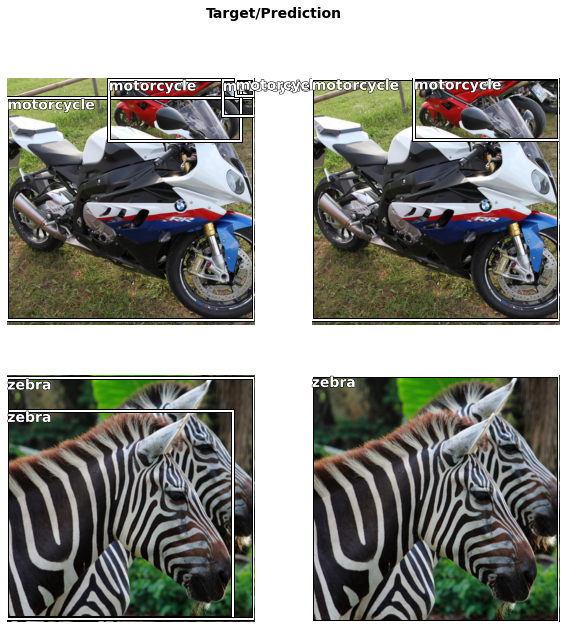

In [ ]:
with learn.removed_cbs(learn.coco_eval):
    learn.show_results(max_n=8, figsize=(10,10))

In [ ]:
url = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fbarkpost.com%2Fwp-content%2Fuploads%2F2014%2F06%2FDOG-2-superJumbo.jpg&f=1&nofb=1'

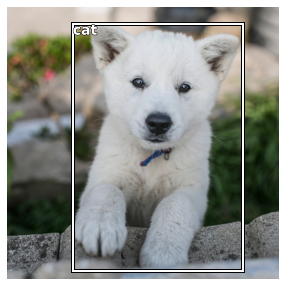

In [ ]:
with learn.removed_cbs(learn.coco_eval):
    img = PILImage.create(requests.get(url, stream=True).raw)
    out = learn.predict(img, with_input=True)
    ctx = show_image(out[0])
    out[1][1].show(ctx);

The prediction is not perfect. I believe this is because we are resizing our images to 800x800 while the DETR model was trained with a different preprocessing method. Now we put everything together into a learner and dataloader contructurs and we train the model to see if gets better.

## CocoDataLoaders

To create a `CocoDataLoaders` we need to define the getter functions. Since pickle can not serilaze nested or 
anonimus functions we use classes to define these getters. I did not find a better way to do this.

In [ ]:
#export
class GetAnnotatedImageFiles:
    def __init__(self, img2bbox): self.img2bbox = img2bbox
    def __call__(self, x): return compose(get_image_files, partial(filter, compose(attrgetter('name'), self.img2bbox.__contains__)), L)(x)
class GetBboxAnnotation:
    def __init__(self, img2bbox): self.img2bbox = img2bbox
    def __call__(self, x): return compose(attrgetter('name'), self.img2bbox.__getitem__, itemgetter(0))(x)
class GetClassAnnotation:
    def __init__(self, img2bbox): self.img2bbox = img2bbox
    def __call__(self, x): return compose(attrgetter('name'), self.img2bbox.__getitem__, itemgetter(1))(x)

In [ ]:
#export
class CocoDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path(cls, path, train='train', valid='val', vocab=None, bs=16, item_tfms=Resize(800), batch_tfms=None, **kwargs):
        source = Path(path)
        ann_files = source.ls(file_exts='.json')
        train_ann = ann_files.filter(lambda x: x.name.startswith(train))
        assert len(train_ann)==1, 'More than one (or none) training annotation file'
        val_ann = ann_files.filter(lambda x: x.name.startswith(valid))
        assert len(val_ann)<2, 'More than one validation annotation file'
        ann_files = [train_ann[0]]
        if val_ann: ann_files.append(val_ann[0])

        img2bbox = {}
        for ann_file in ann_files: img2bbox = merge(img2bbox, dict(zip(*get_annotations(ann_file))))

        if not vocab: vocab = L(chain(*L(img2bbox.values()).itemgot(1))).unique()
        if not '#na#' in vocab:
            vocab = L(vocab) + '#na#'
        elif '#na#'!=vocab[-1]:
            warn('Empty category #na# should be the last element of the vocab.')
            warn('Moving category #na# at the end of vocab.')
            vocab.pop(vocab.index('#na#'))
            vocab = L(vocab) + '#na#'

        img_folders = source.ls().filter(Self.is_dir())
        train_name = img_folders.filter(Self.name.startswith(train))
        val_name = img_folders.filter(Self.name.startswith(valid))
        assert len(train_name)==1
        train_name = train_name[0].name
        if len(ann_files)==2:
            assert len(val_name)==1
            val_name = val_name[0].name
            splitter = ParentSplitter(train_name=train_name, valid_name=val_name)
        else:
            splitter = RandomSplitter()
            
        BBoxBlock.dls_kwargs = {'before_batch': partial(bb_pad, pad_idx=len(vocab)-1)}

        dblock = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock(vocab=list(vocab), add_na=False)), 
                 get_items=GetAnnotatedImageFiles(img2bbox),
                 splitter=splitter,
                 get_y=[GetBboxAnnotation(img2bbox), GetClassAnnotation(img2bbox)], 
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)
        return cls.from_dblock(dblock, source, bs=bs, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_sources(cls, sources, vocab=None, bs=16, item_tfms=Resize(800), batch_tfms=None, **kwargs):
        ann_files = [sources['train_ann'], sources['val_ann']]
        img2bbox = {}
        for ann_file in ann_files: img2bbox = merge(img2bbox, dict(zip(*get_annotations(ann_file))))

        if not vocab: vocab = L(chain(*L(img2bbox.values()).itemgot(1))).unique()
        if not '#na#' in vocab:
            vocab = L(vocab) + '#na#'
        elif '#na#'!=vocab[-1]:
            warn('Empty category #na# should be the last element of the vocab.')
            warn('Moving category #na# at the end of vocab.')
            vocab.pop(vocab.index('#na#'))
            vocab = L(vocab) + '#na#'

        splitter = ParentSplitter(train_name=sources['train'].name, valid_name=sources['val'].name)
            
        BBoxBlock.dls_kwargs = {'before_batch': partial(bb_pad, pad_idx=len(vocab)-1)}

        dblock = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock(vocab=list(vocab), add_na=False)), 
                 get_items=GetAnnotatedImageFiles(img2bbox),
                 splitter=splitter,
                 get_y=[GetBboxAnnotation(img2bbox), GetClassAnnotation(img2bbox)], 
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)
        return cls.from_dblock(dblock, sources['base'], bs=bs, **kwargs)

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
dls = CocoDataLoaders.from_path(coco_source, item_tfms=None)

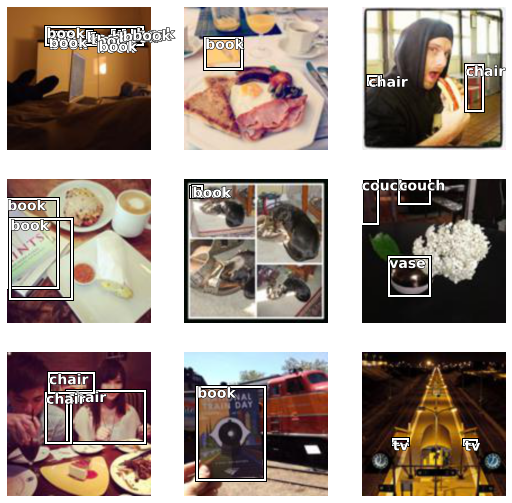

In [ ]:
dls.show_batch()

## DETR Learner

We put everything together into a `Learner`.

In [ ]:
#export
def detr_learner(dls, pretrained=True, bs=16):
    model = DETR(pretrained=pretrained, n_classes=len(dls.vocab), aux_loss=True)
    loss = DETRLoss(classw=1, boxw=5, giouw=2).cuda()
    ce = CocoEval()
    learn = Learner(dls, model, loss, splitter=sorted_detr_trainable_params,
                    cbs=[ce], metrics=ce.metrics,
                    opt_func=partial(Adam, decouple_wd=True))
    learn.coco_eval = ce
    return learn

In [ ]:
coco_source = Path(os.environ['HOME']) / '.fastai/data/coco'
dls = CocoDataLoaders.from_path(coco_source, vocab=coco_vocab, num_workers=0)
learn = detr_learner(dls)

Using cache found in /home/andres/.cache/torch/hub/facebookresearch_detr_master


We fit using learning rates 1e-5 instead of `[1e-5, 1e-4, 1e-4]` because we start with pretrained wrights.

In [ ]:
learn.fit(1, lr=[1e-5, 1e-5, 1e-5])

epoch,train_loss,valid_loss,AP,AP50,AP75,AP_small,AP_medium,AP_large,AR1,AR10,AR100,AR_small,AR_medium,AR_large,time
0,6.090707,7.575320,0.486496,0.584230,0.515506,0.315264,0.468689,0.575824,0.359496,0.555556,0.572914,0.393723,0.556166,0.644320,2:23:17


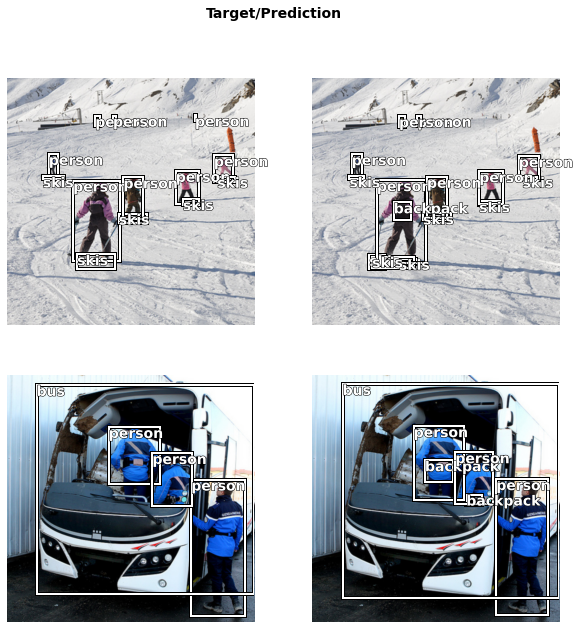

In [ ]:
with learn.removed_cbs(learn.coco_eval):
    learn.show_results(max_n=8, figsize=(10,10))

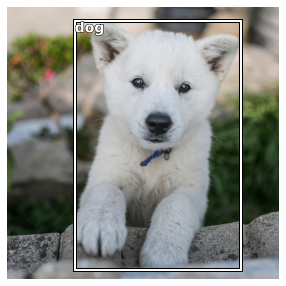

In [ ]:
img = PILImage.create(requests.get(url, stream=True).raw)
with learn.removed_cbs(learn.coco_eval):
    out = learn.predict(img, with_input=True)
ctx = show_image(out[0])
out[1][1].show(ctx);

In [ ]:
learn_to_save = Learner(learn.dls, learn.model, learn.loss_func)
learn_to_save.export('DETR_800x800px.pkl')

In [ ]:
learn_inf = load_learner('DETR_800x800px.pkl')

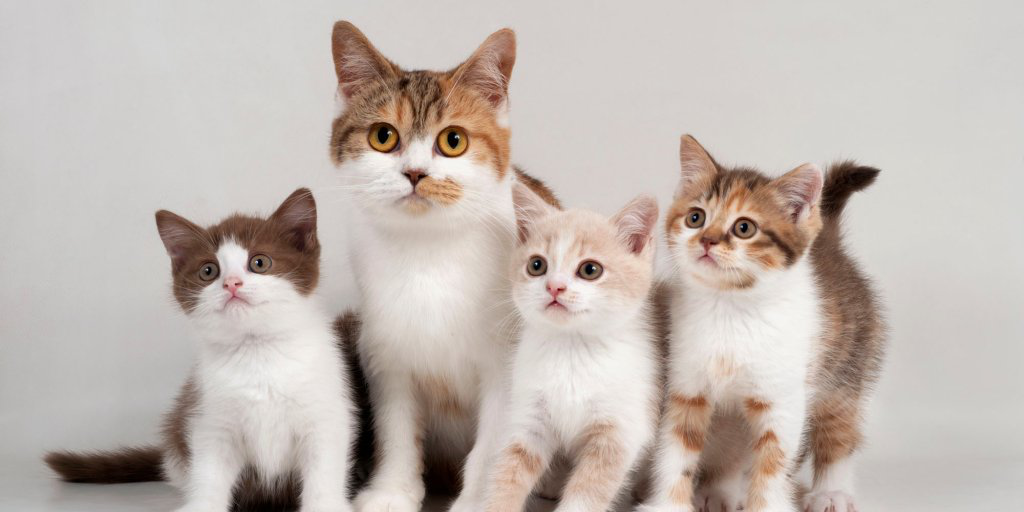

In [ ]:
img2 = PILImage.create(requests.get('https://api.time.com/wp-content/uploads/2015/02/cats.jpg?quality=85&w=1024&h=512&crop=1', stream=True).raw)
img2

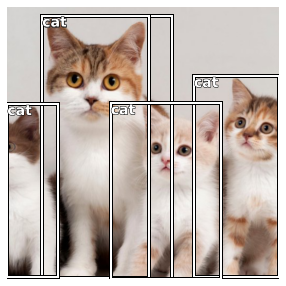

In [ ]:
out = learn_inf.predict(img2, with_input=True)
ctx = show_image(out[0])
out[1][1][1] = L(out[1][1][1])
lbbox = out[1][1].map(Self[learn_inf.loss_func.scores[0]>0.8])
lbbox[0] = TensorBBox(lbbox[0])
lbbox.show(ctx);

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted 03_johnson2016perceptual.ipynb.
Converted 04_carion2020end.ipynb.
Converted index.ipynb.
